In [47]:
import numpy as np

# Create a Generator using MT19937
bitgen = np.random.MT19937(seed=42)
rng = np.random.Generator(bitgen)

# Use this generator to sample
print(rng.uniform(0, 1, 1))  # Now uses seeded MT19937

[0.54199389]


In [48]:
#import numpy as np
import random
import heapq
from scipy.stats import t
from scipy import stats
import matplotlib.pyplot as plt

#### Primary tasks


1. Build a simulation model that simulates the patient 
ow in the hospital as a function of the bed
distribution and the aforementioned parameters.

### 1. Simulation of the hospital queuing system

The goal of this simulation model is to replicate the patient flow within a hospital over a fixed period (e.g., 365 days), based on real-world data and assumptions. The model focuses on five patient types (A–E), each corresponding to a specific hospital ward (A–E), and simulates:

- How patients arrive according to exponentially distributed inter-arrival times (i.e., Poisson arrival process).
- How they are admitted, transferred, or blocked based on current ward capacity.
- How long they stay in the hospital based on an exponential distribution for length of stay.

The primary purpose is to evaluate how the **distribution of available beds across different wards** affects key performance indicators such as:

- Number of patient admissions
- Number of blocked patients (not admitted due to full capacity)
- Frequency and success of transfers to alternative wards
- Total urgency penalties for patients not admitted to their correct ward
- Utilization rate of each ward (how effectively beds are used over time)

By modeling these processes and adjusting the **bed allocation (ward capacity)**, the simulation provides insights into hospital performance and helps identify better bed distribution strategies. 

Goal of the simulation

In [51]:
# Given Parameters
WARDS = ['A', 'B', 'C', 'D', 'E', 'F']
arrival_rates = {'A': 14.5, 'B': 11.0, 'C': 8.0, 'D': 6.5, 'E': 5.0, 'F': 13.0}
stay_means = {'A': 2.9, 'B': 4.0, 'C': 4.5, 'D': 1.4, 'E': 3.9, 'F': 2.2}
urgency_points = {'A': 7, 'B': 5, 'C': 2, 'D': 10, 'E': 5, 'F': 0}
initial_beds = {'A': 55, 'B': 40, 'C': 30, 'D': 20, 'E': 20, 'F': 5}
relocation_probs = {
    'A': {'B': 0.05, 'C': 0.10, 'D': 0.05, 'E': 0.80},
    'B': {'A': 0.20, 'C': 0.50, 'D': 0.15, 'E': 0.15},
    'C': {'A': 0.30, 'B': 0.20, 'D': 0.20, 'E': 0.30},
    'D': {'A': 0.35, 'B': 0.30, 'C': 0.05, 'E': 0.30},
    'E': {'A': 0.20, 'B': 0.10, 'C': 0.60, 'D': 0.10},
    'F': {'A': 0.20, 'B': 0.20, 'C': 0.20, 'D': 0.20, 'E': 0.20}
}

# Initialization Function
def initialize_events(days=365):
    event_list = []
    np.random.seed(0)
    for ptype in WARDS:
        # no. of arrivals to simulate
        num_arrivals = int( arrival_rates[ptype] * days * 1.2 ) # argument for buffer
        # mean time between arrivals
        mean_interarrival_time = 1 / arrival_rates[ptype]
        # Generate interarrival time
        interarrival_times = np.random.exponential(mean_interarrival_time, num_arrivals)
        arrivals = np.cumsum(interarrival_times)
        for t in arrivals:
            if t < days:
                heapq.heappush(event_list, (t, 'Arr', ptype))
    return event_list

# Event Handling
def handle_arrival(event, bed, stay_means, penalties, blocked, event_list,
                   patients_total, patients_admitted, patients_relocated, patients_lost):
    time, _, ptype = event
    patients_total[ptype] += 1
    if bed[ptype] > 0:
        bed[ptype] -= 1
        los = np.random.exponential(stay_means[ptype]) # length of stay
        heapq.heappush(event_list, (time + los, 'Dep', ptype))
    else: # If no bed is available
        penalties[ptype] += urgency_points[ptype]
        dests = list(relocation_probs[ptype].keys())
        probs = list(relocation_probs[ptype].values())
        dest = random.choices(dests, probs)[0] #We randomly choose a destination ward based on these prob
        heapq.heappush(event_list, (time, 'Tra', (ptype, dest)))  # same time for transfer
    return bed, penalties, blocked

def handle_departure(event, bed):
    _, _, ptype = event
    bed[ptype] += 1
    return bed


def handle_transfer(event, bed, stay_means, penalties, blocked, event_list,
                    patients_relocated, patients_lost, patients_admitted):
    time, _, (from_type, dest) = event
    if bed[dest] > 0:
        bed[dest] -= 1
        patients_relocated[from_type] += 1
        patients_admitted[dest] += 1  # count as admitted in destination
        los = np.random.exponential(stay_means[from_type])
        heapq.heappush(event_list, (time + los, 'Dep', dest))
    else:
        patients_lost[from_type] += 1
        blocked += 1
    return bed, penalties, blocked

# Main Simulation Function
def simulate_hospital_flow(days=365):
    bed = initial_beds.copy()
    penalties = {w: 0 for w in WARDS}
    blocked = 0
    event_list = initialize_events(days)

    patients_total = {w: 0 for w in WARDS}
    patients_admitted = {w: 0 for w in WARDS}
    patients_relocated = {w: 0 for w in WARDS}
    patients_lost = {w: 0 for w in WARDS}

    while event_list:
        event = heapq.heappop(event_list)
        event_type = event[1]

        if event_type == 'Arr':
            bed, penalties, blocked = handle_arrival(
                event, bed, stay_means, penalties, blocked, event_list,
                patients_total, patients_admitted, patients_relocated, patients_lost)

        elif event_type == 'Dep':
            bed = handle_departure(event, bed)

        elif event_type == 'Tra':
            bed, penalties, blocked = handle_transfer(
            event, bed, stay_means, penalties, blocked, event_list,
            patients_relocated, patients_lost, patients_admitted)

    # Output results
    print("\n--- Simulation Results ---")
    for w in WARDS:
        print(f"Ward {w}")
        print(f"  N: patients   = {patients_total[w]}")
        print(f"  N: admitted   = {patients_admitted[w]}")
        print(f"  N: relocated  = {patients_relocated[w]}")
        print(f"  N: lost       = {patients_lost[w]}")
        print(f"  Penalty       = {penalties[w]}")
    print(f"\nTotal blocked patients: {blocked}")

    return (patients_total, patients_admitted, patients_relocated, patients_lost, penalties, blocked)

# ▶ Run it
simulate_hospital_flow()



--- Simulation Results ---
Ward A
  N: patients   = 5322
  N: admitted   = 1503
  N: relocated  = 250
  N: lost       = 307
  Penalty       = 3899
Ward B
  N: patients   = 4066
  N: admitted   = 860
  N: relocated  = 717
  N: lost       = 426
  Penalty       = 5715
Ward C
  N: patients   = 3002
  N: admitted   = 933
  N: relocated  = 908
  N: lost       = 356
  Penalty       = 2528
Ward D
  N: patients   = 2346
  N: admitted   = 1070
  N: relocated  = 285
  N: lost       = 136
  Penalty       = 4210
Ward E
  N: patients   = 1760
  N: admitted   = 998
  N: relocated  = 442
  N: lost       = 264
  Penalty       = 3530
Ward F
  N: patients   = 4688
  N: admitted   = 0
  N: relocated  = 2762
  N: lost       = 1155
  Penalty       = 0

Total blocked patients: 2644


({'A': 5322, 'B': 4066, 'C': 3002, 'D': 2346, 'E': 1760, 'F': 4688},
 {'A': 1503, 'B': 860, 'C': 933, 'D': 1070, 'E': 998, 'F': 0},
 {'A': 250, 'B': 717, 'C': 908, 'D': 285, 'E': 442, 'F': 2762},
 {'A': 307, 'B': 426, 'C': 356, 'D': 136, 'E': 264, 'F': 1155},
 {'A': 3899, 'B': 5715, 'C': 2528, 'D': 4210, 'E': 3530, 'F': 0},
 2644)

#### Plotting


--- Simulation Results ---
Ward A
  N: patients   = 5322
  N: admitted   = 1505
  N: relocated  = 245
  N: lost       = 346
  Penalty       = 4137
Ward B
  N: patients   = 4066
  N: admitted   = 816
  N: relocated  = 758
  N: lost       = 462
  Penalty       = 6100
Ward C
  N: patients   = 3002
  N: admitted   = 962
  N: relocated  = 925
  N: lost       = 382
  Penalty       = 2614
Ward D
  N: patients   = 2346
  N: admitted   = 1092
  N: relocated  = 238
  N: lost       = 108
  Penalty       = 3460
Ward E
  N: patients   = 1760
  N: admitted   = 952
  N: relocated  = 429
  N: lost       = 260
  Penalty       = 3445
Ward F
  N: patients   = 4688
  N: admitted   = 0
  N: relocated  = 2732
  N: lost       = 1129
  Penalty       = 0

Total blocked patients: 2687


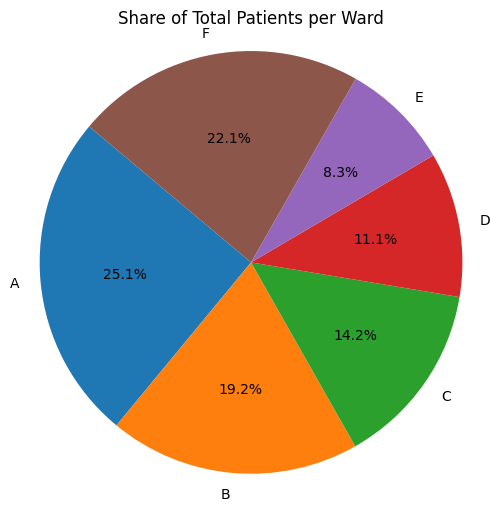

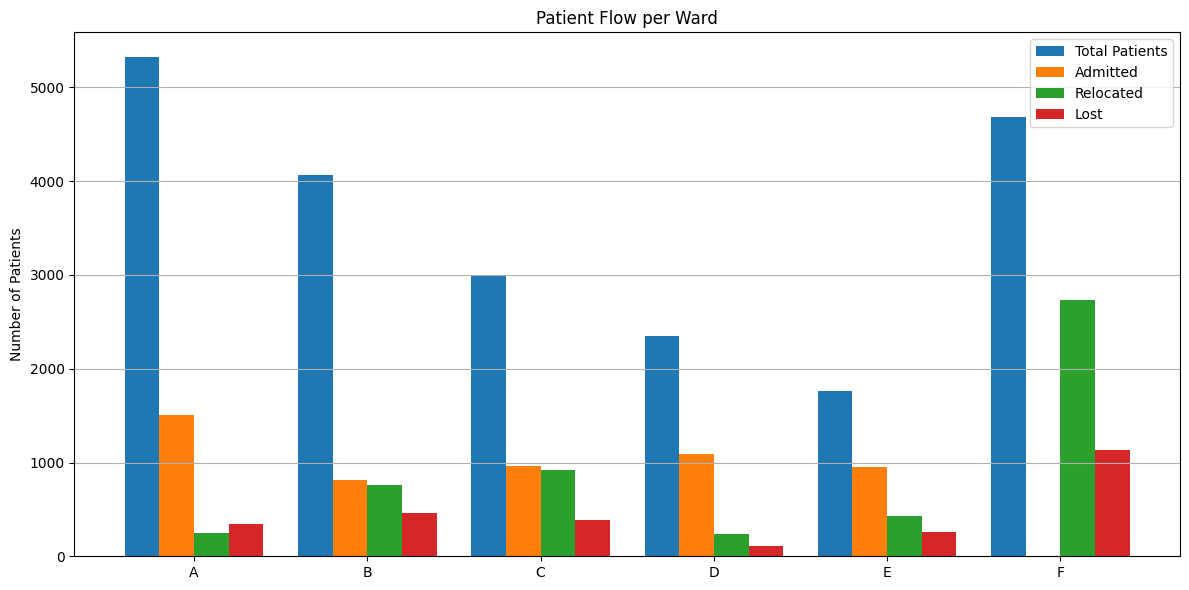

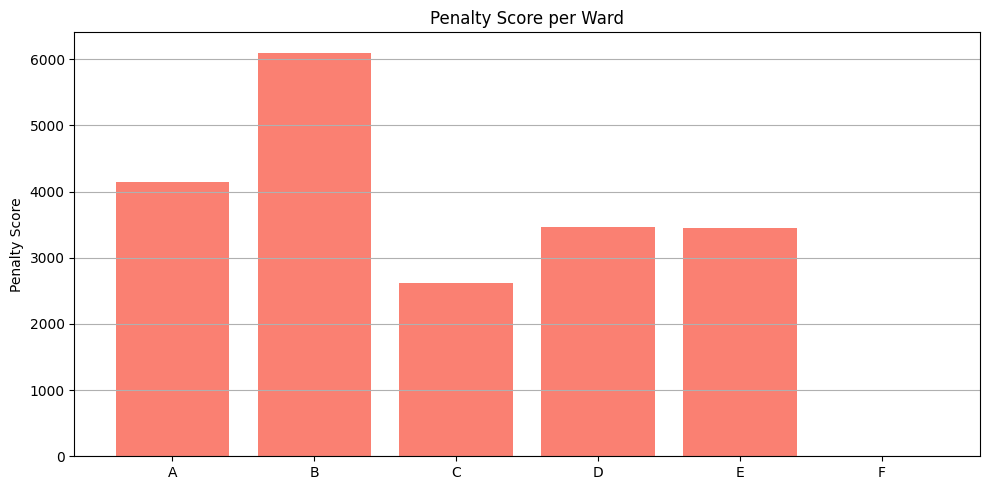

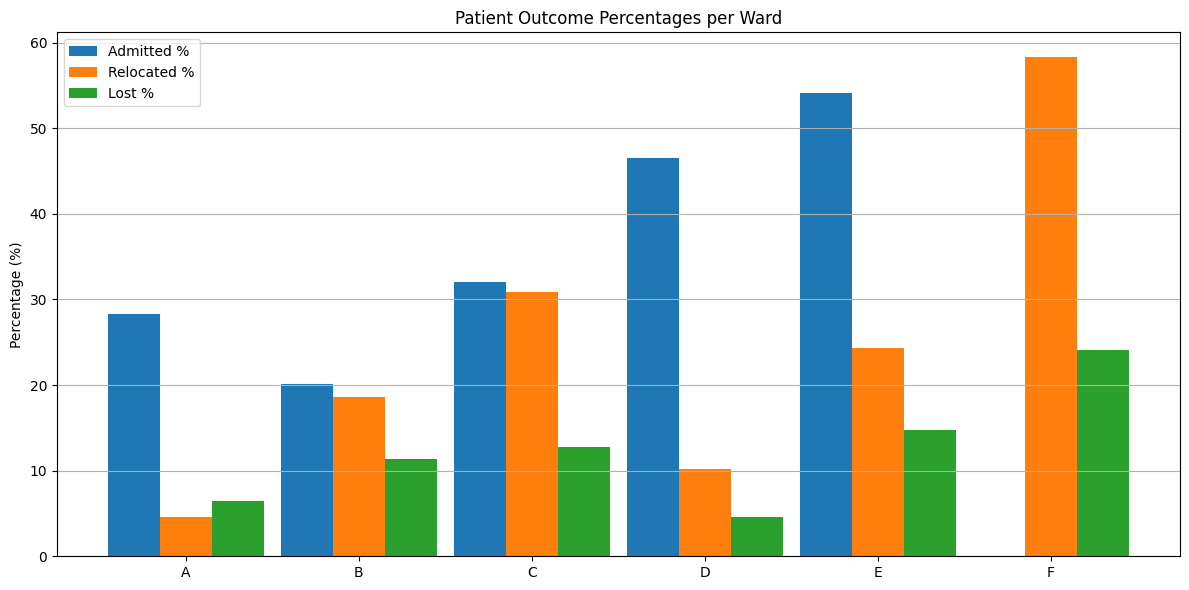

In [43]:
import matplotlib.pyplot as plt
import numpy as np

def plot_penalties(penalties):
    wards = list(penalties.keys())
    scores = [penalties[w] for w in wards]

    plt.figure(figsize=(10, 5))
    plt.bar(wards, scores, color='salmon')
    plt.ylabel('Penalty Score')
    plt.title('Penalty Score per Ward')
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()


# --- Pie Chart: Share of Total Patients per Ward ---
def plot_pie_total_patients(patients_total):
    labels = patients_total.keys()
    sizes = patients_total.values()

    plt.figure(figsize=(6, 6))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.title('Share of Total Patients per Ward')
    plt.axis('equal')
    plt.show()

# --- Bar Plot: Percentages of Outcomes per Ward ---
def plot_outcome_percentages(patients_total, patients_admitted, patients_relocated, patients_lost):
    wards = list(patients_total.keys())
    admitted_pct = [patients_admitted[w] / patients_total[w] * 100 if patients_total[w] > 0 else 0 for w in wards]
    relocated_pct = [patients_relocated[w] / patients_total[w] * 100 if patients_total[w] > 0 else 0 for w in wards]
    lost_pct = [patients_lost[w] / patients_total[w] * 100 if patients_total[w] > 0 else 0 for w in wards]

    x = np.arange(len(wards))
    width = 0.3

    plt.figure(figsize=(12, 6))
    plt.bar(x - width, admitted_pct, width, label='Admitted %')
    plt.bar(x, relocated_pct, width, label='Relocated %')
    plt.bar(x + width, lost_pct, width, label='Lost %')

    plt.xticks(x, wards)
    plt.ylabel('Percentage (%)')
    plt.title('Patient Outcome Percentages per Ward')
    plt.legend()
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

# --- Bar Plot: Raw Patient Flow Counts ---
def plot_patient_flow(patients_total, patients_admitted, patients_relocated, patients_lost):
    wards = list(patients_total.keys())
    totals = [patients_total[w] for w in wards]
    admitted = [patients_admitted[w] for w in wards]
    relocated = [patients_relocated[w] for w in wards]
    lost = [patients_lost[w] for w in wards]

    x = np.arange(len(wards))
    width = 0.2

    plt.figure(figsize=(12, 6))
    plt.bar(x - 1.5*width, totals, width, label='Total Patients')
    plt.bar(x - 0.5*width, admitted, width, label='Admitted')
    plt.bar(x + 0.5*width, relocated, width, label='Relocated')
    plt.bar(x + 1.5*width, lost, width, label='Lost')

    plt.xticks(x, wards)
    plt.ylabel('Number of Patients')
    plt.title('Patient Flow per Ward')
    plt.legend()
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()

# --- Bar Plot: Penalty Scores per Ward ---
def plot_penalties(penalties):
    wards = list(penalties.keys())
    scores = [penalties[w] for w in wards]

    plt.figure(figsize=(10, 5))
    plt.bar(wards, scores, color='salmon')
    plt.ylabel('Penalty Score')
    plt.title('Penalty Score per Ward')
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

# --- Run the Simulation and Visualize ---
pt, pa, pr, pl, pen, block = simulate_hospital_flow()

plot_pie_total_patients(pt)
plot_patient_flow(pt, pa, pr, pl)
plot_penalties(pen)
plot_outcome_percentages(pt, pa, pr, pl)


#### identify the worst-performing wards

In [44]:
def highlight_worst_ward(patients_total, patients_admitted, patients_relocated, patients_lost, penalties):
    worst_penalty_ward = max(penalties, key=penalties.get)

    lost_pct = {w: (patients_lost[w] / patients_total[w] * 100 if patients_total[w] > 0 else 0) for w in patients_total}
    worst_lost_pct_ward = max(lost_pct, key=lost_pct.get)

    admitted_pct = {w: (patients_admitted[w] / patients_total[w] * 100 if patients_total[w] > 0 else 0) for w in patients_total}
    worst_admit_pct_ward = min(admitted_pct, key=admitted_pct.get)

    print("\n--- 🚨 Worst Performing Wards ---")
    print(f"🔴 Highest Penalty: Ward {worst_penalty_ward} (Score = {penalties[worst_penalty_ward]})")
    print(f"🔴 Highest % Lost: Ward {worst_lost_pct_ward} ({lost_pct[worst_lost_pct_ward]:.2f}%)")
    print(f"🔴 Lowest % Admitted: Ward {worst_admit_pct_ward} ({admitted_pct[worst_admit_pct_ward]:.2f}%)")

    return worst_penalty_ward, worst_lost_pct_ward, worst_admit_pct_ward

highlight_worst_ward(pt, pa, pr, pl, pen)




--- 🚨 Worst Performing Wards ---
🔴 Highest Penalty: Ward B (Score = 6100)
🔴 Highest % Lost: Ward F (24.08%)
🔴 Lowest % Admitted: Ward F (0.00%)


('B', 'F', 'F')

#### Probability of Full Bed at Arrival

It measures how often a patient arrives to find their assigned ward full, across multiple simulation runs.

This metric gives you insight into ward congestion and system performance under load.

In [45]:
def estimate_full_bed_prob(runs=100, days=365):
    full_bed_counts = {w: 0 for w in WARDS}
    total_arrivals = {w: 0 for w in WARDS}

    for _ in range(runs):
        bed = initial_beds.copy()
        penalties = {w: 0 for w in WARDS}
        blocked = 0
        event_list = initialize_events(days)

        patients_total = {w: 0 for w in WARDS}
        patients_admitted = {w: 0 for w in WARDS}
        patients_relocated = {w: 0 for w in WARDS}
        patients_lost = {w: 0 for w in WARDS}

        while event_list:
            event = heapq.heappop(event_list)
            event_type = event[1]

            if event_type == 'Arr':
                time, _, ptype = event
                total_arrivals[ptype] += 1
                if bed[ptype] > 0:
                    bed[ptype] -= 1
                    los = np.random.exponential(stay_means[ptype])
                    heapq.heappush(event_list, (time + los, 'Dep', ptype))
                else:
                    full_bed_counts[ptype] += 1
                    dests = list(relocation_probs[ptype].keys())
                    probs = list(relocation_probs[ptype].values())
                    dest = random.choices(dests, probs)[0]
                    heapq.heappush(event_list, (time, 'Tra', (ptype, dest)))

            elif event_type == 'Dep':
                bed = handle_departure(event, bed)

            elif event_type == 'Tra':
                bed, penalties, blocked = handle_transfer(
                    event, bed, stay_means, penalties, blocked, event_list,
                    patients_relocated, patients_lost, patients_admitted)

    # Compute probabilities
    prob_full_bed = {w: full_bed_counts[w] / total_arrivals[w] if total_arrivals[w] > 0 else 0 for w in WARDS}

    # Print nicely
    print("\n--- Probability of Full Bed at Arrival (over 100 runs) ---")
    for w in WARDS:
        print(f"Ward {w}: {prob_full_bed[w]:.3f}")

    return prob_full_bed
prob_full = estimate_full_bed_prob()


--- Probability of Full Bed at Arrival (over 100 runs) ---
Ward A: 0.113
Ward B: 0.284
Ward C: 0.438
Ward D: 0.154
Ward E: 0.418
Ward F: 0.828


Interpretation

Ward F* has the highest bed blocking rate: 82.6% of the time, a patient of type F* arrives to a full ward. This is extremely high, and implies that even with 41 beds, demand for F* is very high compared to its capacity.

Wards C and E are also under pressure with ~40–44% full bed probabilities. This suggests they may have too few beds relative to their patient load and length of stay.

Wards A and D are performing well, with low blocking probabilities (11–15%). This might mean these wards are more adequately resourced—or even overprovisioned

#### Probability of Full Bed at Arrival


In [ ]:

# --- Parameters ---
WARDS = ['A', 'B', 'C', 'D', 'E']
arrival_rates = {'A': 14.5, 'B': 11.0, 'C': 8.0, 'D': 6.5, 'E': 5.0}
stay_means = {'A': 2.9, 'B': 4.0, 'C': 4.5, 'D': 1.4, 'E': 3.9}
initial_beds = {'A': 55, 'B': 40, 'C': 30, 'D': 20, 'E': 20}

# --- Simulation Function (Simplified to Count Full Beds) ---
def simulate_bed_full_prob(n_patients=10000, burn_in=1000):
    beds = initial_beds.copy()
    occupied_until = {w: [] for w in WARDS}
    np.random.seed()
    full_counts = {w: 0 for w in WARDS}
    arrival_counts = {w: 0 for w in WARDS}

    for _ in range(n_patients):
        ptype = random.choice(WARDS)
        arrival_time = np.random.exponential(1 / arrival_rates[ptype])

        # Remove patients who have left before now
        occupied_until[ptype] = [t for t in occupied_until[ptype] if t > arrival_time]
        arrival_counts[ptype] += 1

        if len(occupied_until[ptype]) >= initial_beds[ptype]:
            full_counts[ptype] += 1
        else:
            los = np.random.exponential(stay_means[ptype])
            occupied_until[ptype].append(arrival_time + los)

    # Return proportion of full bed encounters
    return {w: full_counts[w] / arrival_counts[w] for w in WARDS}

# --- Run Multiple Simulations ---
def run_multiple_simulations(k=100):
    results = {w: [] for w in WARDS}
    for _ in range(k):
        res = simulate_bed_full_prob()
        for w in WARDS:
            results[w].append(res[w])
    return results

# --- Calculate Mean, Variance, and 95% CI ---
def analyze_results(results):
    stats = {}
    for w in WARDS:
        data = np.array(results[w])
        mean = np.mean(data)
        var = np.var(data, ddof=1)
        se = np.sqrt(var / len(data))
        tval = t.ppf(0.975, df=len(data) - 1)
        ci_low = mean - tval * se
        ci_high = mean + tval * se
        stats[w] = {
            'Mean': round(mean, 4),
            'Variance': round(var, 6),
            'CI_lower': round(ci_low, 4),
            'CI_upper': round(ci_high, 4)
        }
    return stats

# ▶ Run and Display
results = run_multiple_simulations(k=100)
stats = analyze_results(results)

print("\nProbability of Full Bed at Arrival (100 runs):")
print(f"{'Ward':<5} {'Mean':<8} {'Variance':<10} {'Lower 95% CI':<15} {'Upper 95% CI':<15}")
for w in WARDS:
    s = stats[w]
    print(f"{w:<5} {s['Mean']:<8} {s['Variance']:<10} {s['CI_lower']:<15} {s['CI_upper']:<15}")



Probability of Full Bed at Arrival (100 runs):
Ward  Mean     Variance   Lower 95% CI    Upper 95% CI   
A     0.9677   4e-06      0.9673          0.9682         
B     0.9768   2e-06      0.9765          0.9771         
C     0.9818   2e-06      0.9816          0.9821         
D     0.9806   1e-05      0.98            0.9812         
E     0.9861   4e-06      0.9857          0.9865         


#### Add Ward F and Allocate Beds Wisely

1. Target improvement for Ward F*
Your goal is to ensure no more than 5% of F* patients are relocated or lost. But with an 82.6% full bed rate, that means:

Either F* needs more beds.

Or some patient types need to be relocated less often to F* (e.g., adjusting relocation probabilities).

Or reduce load via shorter length of stay (not always feasible).

2. Resource Rebalancing
You could explore reallocating beds:

Take a few beds from Ward A and D (where blocking is low),

Give those beds to Ward F or to high-pressure wards like C or E.

This is what you're trying to do in optimization: minimize penalty scores while ensuring F* patients are mostly treated in F*.

What to do next?
Try different bed allocations and rerun simulations.

For each configuration, record:

F* relocation rate

Penalty score

Full bed probabilities for all wards

Choose configuration that:

Achieves < 5% loss for F*

Keeps total penalty low

Avoids extreme overload in any single ward

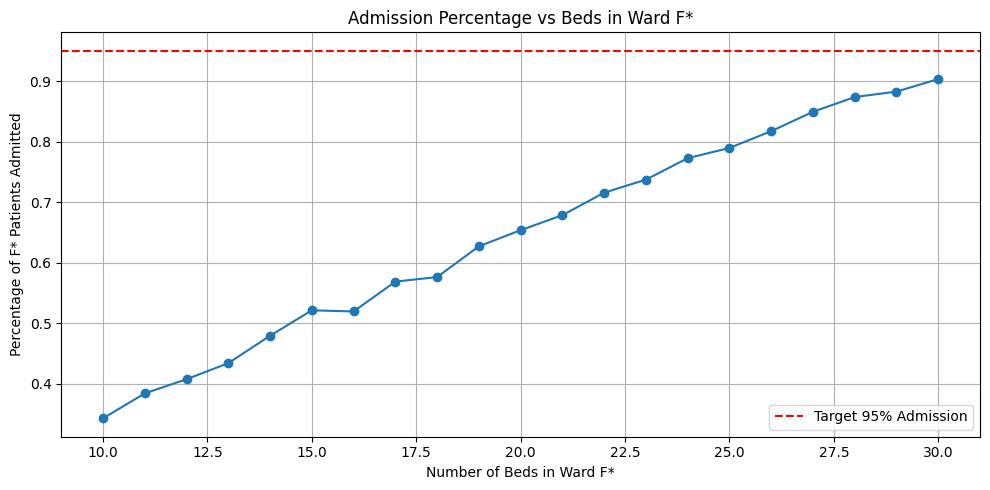

In [ ]:
import numpy as np
import random
import heapq
import matplotlib.pyplot as plt

# --- Parameters ---
WARDS = ['A', 'B', 'C', 'D', 'E', 'F']
arrival_rates = {'A': 14.5, 'B': 11.0, 'C': 8.0, 'D': 6.5, 'E': 5.0, 'F': 13.0}
stay_means = {'A': 2.9, 'B': 4.0, 'C': 4.5, 'D': 1.4, 'E': 3.9, 'F': 2.2}
urgency_points = {'A': 7, 'B': 5, 'C': 2, 'D': 10, 'E': 5, 'F': 0}
relocation_probs = {
    'A': {'B': 0.05, 'C': 0.10, 'D': 0.05, 'E': 0.80},
    'B': {'A': 0.20, 'C': 0.50, 'D': 0.15, 'E': 0.15},
    'C': {'A': 0.30, 'B': 0.20, 'D': 0.20, 'E': 0.30},
    'D': {'A': 0.35, 'B': 0.30, 'C': 0.05, 'E': 0.30},
    'E': {'A': 0.20, 'B': 0.10, 'C': 0.60, 'D': 0.10},
    'F': {'A': 0.20, 'B': 0.20, 'C': 0.20, 'D': 0.20, 'E': 0.20}
}

# --- Helper Functions ---
def initialize_events(days=365):
    event_list = []
    np.random.seed(0)
    for ptype in WARDS:
        num_arrivals = int(arrival_rates[ptype] * days * 1.2)
        interarrival_times = np.random.exponential(1 / arrival_rates[ptype], num_arrivals)
        arrivals = np.cumsum(interarrival_times)
        for t in arrivals:
            if t < days:
                heapq.heappush(event_list, (t, 'Arr', ptype))
    return event_list

def handle_arrival(event, bed, penalties, blocked, event_list, patients_total, patients_admitted, patients_relocated, patients_lost):
    time, _, ptype = event
    patients_total[ptype] += 1
    if bed[ptype] > 0:
        bed[ptype] -= 1
        los = np.random.exponential(stay_means[ptype])
        heapq.heappush(event_list, (time + los, 'Dep', ptype))
        patients_admitted[ptype] += 1
    else:
        penalties[ptype] += urgency_points[ptype]
        dests = list(relocation_probs[ptype].keys())
        probs = list(relocation_probs[ptype].values())
        dest = random.choices(dests, probs)[0]
        heapq.heappush(event_list, (time, 'Tra', (ptype, dest)))
    return bed, penalties, blocked

def handle_departure(event, bed):
    _, _, ptype = event
    bed[ptype] += 1
    return bed

def handle_transfer(event, bed, penalties, blocked, event_list, patients_relocated, patients_lost, patients_admitted):
    time, _, (from_type, dest) = event
    if bed[dest] > 0:
        bed[dest] -= 1
        patients_relocated[from_type] += 1
        patients_admitted[dest] += 1
        los = np.random.exponential(stay_means[from_type])
        heapq.heappush(event_list, (time + los, 'Dep', dest))
    else:
        patients_lost[from_type] += 1
        blocked += 1
    return bed, penalties, blocked

def simulate_hospital_flow(initial_beds, days=365):
    bed = initial_beds.copy()
    penalties = {w: 0 for w in WARDS}
    blocked = 0
    event_list = initialize_events(days)

    patients_total = {w: 0 for w in WARDS}
    patients_admitted = {w: 0 for w in WARDS}
    patients_relocated = {w: 0 for w in WARDS}
    patients_lost = {w: 0 for w in WARDS}

    while event_list:
        event = heapq.heappop(event_list)
        event_type = event[1]

        if event_type == 'Arr':
            bed, penalties, blocked = handle_arrival(event, bed, penalties, blocked, event_list,
                                                     patients_total, patients_admitted, patients_relocated, patients_lost)
        elif event_type == 'Dep':
            bed = handle_departure(event, bed)
        elif event_type == 'Tra':
            bed, penalties, blocked = handle_transfer(event, bed, penalties, blocked, event_list,
                                                      patients_relocated, patients_lost, patients_admitted)

    return patients_total, patients_admitted, patients_relocated, patients_lost, penalties, blocked

# --- Run over different allocations to F ---
results = []
total_beds = 165
for f_beds in range(10, 31):
    other_beds = total_beds - f_beds
    share = other_beds / 5
    initial_beds = {'A': int(share), 'B': int(share), 'C': int(share), 'D': int(share), 'E': total_beds - f_beds - 4*int(share), 'F': f_beds}
    pt, pa, pr, pl, pen, block = simulate_hospital_flow(initial_beds)
    admitted_pct = pa['F'] / pt['F'] if pt['F'] > 0 else 0
    results.append((f_beds, pt['F'], pa['F'], pr['F'], pl['F'], round(admitted_pct, 4)))

results

# Extract data for plotting
f_beds_vals = [r[0] for r in results]
admit_pct = [r[-1] for r in results]

# Plot admission percentage vs number of F beds
plt.figure(figsize=(10, 5))
plt.plot(f_beds_vals, admit_pct, marker='o', linestyle='-')
plt.axhline(0.95, color='red', linestyle='--', label='Target 95% Admission')
plt.xlabel('Number of Beds in Ward F*')
plt.ylabel('Percentage of F* Patients Admitted')
plt.title('Admission Percentage vs Beds in Ward F*')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


This plot shows how the percentage of F* patients admitted changes as we allocate more beds to Ward F*.
Optimization Goal: Find the smallest number of beds where the curve crosses or exceeds the 95% line.

Patient flow through hospital wards, focusing on bed occupancy, patient admission, relocation, and loss, and evaluates the penalty scores associated with patient mismanagement.